# Dive into Abusive Language with Snorkel

Author: BingYune Chen 
<br>
Updated: 2021-08-02

----------

### Train BERT using Snorkel labels

We just completed the following step to work with our BERT model:

1. Fine-tuned BERT model using Sentiment140 to generalize on Twitter data
2. Trained BERT model using Ground Truth labels

**We will now train our fine-tuned BERT model (Step 1) using Snorkel labels for X_train to compare against the BERT model trained using Ground Truth labels for X_train (Step 2).**

In [ ]:
# Imports and setup for Google Colab

# Mount Google Drive
from google.colab import drive ## module to use Google Drive with Python
drive.mount('/content/drive') ## mount to access contents

# Install python libraries
! pip install --upgrade tensorflow --quiet
! pip install snorkel --quiet
! pip install tensorboard==1.15.0 --quiet
! pip install transformers --quiet

In [ ]:
# Imports for data and plotting
import numpy as np
import pandas as pd

import pickle
import os
import re

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
plt.rcParams["font.family"] = "sans serif"

# Style configuration
COLORS = [
    '#0059ff',
    '#fdbd28',
    '#28D9AA',
    '#EE5149',
    '#060F41',
    '#788995',
    '#FF69B4',
    '#7F00FF',
]
GREY = '#788995'
DARK_GREY = '#060F41'
BLUE = '#0059ff'
DBLUE = '#060F41'
GOLD = '#fdbd28'
GREEN = '#28D9AA'
RED = '#EE5149'
BLACK = '#000000'
WHITE = '#FFFFFF'
LINEWIDTH = 5
LINESPACING = 1.25
FS_SUPTITLE = 30
FS_CAPTION = 24
FS_LABEL = 24
FS_FOOTNOTE = 20

# Imports for snorkel analysis and multi-task learning
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe

# Imports for bert language model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

import transformers

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

import time
import datetime
import random

In [ ]:
# Access notebook directory

# Define paths
LOAD_MODEL = '../models/'
LOAD_LFS = '../archive_git_lfs/models/'
LOAD_DATA = '../data/processed/'

SAVE_MODEL = '../models/'
SAVE_DATA = '../data/published/'

SAVE_FIG = '../assets/'

# Define files for training
TRAIN_FILE = 'df_train.pkl' ## update
TRAIN_LFS_FILE = 'lf_train_final.pkl'

# Define files for validation and testing
VALID_FILE = 'df_valid.pkl'
VALID_LFS_FILE = 'lf_valid_final.pkl'

TEST_FILE = 'df_test.pkl'
TEST_LFS_FILE = 'lf_test_final.pkl'

# Define model names to save and load
MODEL_FILE1 = 'bert_tokens_{}_vf.pkl'.format(TRAIN_FILE[:-4])
MODEL_FILE2 = 'bert_tokens_df_valid.pkl'
MODEL_FILE3 = 'bert_tokens_df_test.pkl'
MODEL_FILE4 = 'bert_trainstats_{}_vf.pt'.format(TRAIN_FILE[:-4])

# Define current version of BERT model to load
BERT_PRE = 'model_bert_ts140_dict.pt' ## update
## fine-tuned on Sentiment140

# Define new version of BERT model to save
BERT_POST_DICT = 'model_bert_{}_dict_vf.pt'.format(TRAIN_FILE[:-4])
BERT_POST_FULL = 'model_bert_{}_full_vf.pt'.format(TRAIN_FILE[:-4])
BERT_POST_CHECKPOINT = 'model_bert_{}_vf_'.format(TRAIN_FILE[:-4])

# Define figure names
FIG_FILE1 = 'lm-conf-matrix-{}-vf.png'.format(TRAIN_FILE[:-4])
FIG_FILE2 = 'bert-train-val-loss-{}-vf.png'.format(TRAIN_FILE[:-4])
FIG_FILE3 = 'bert-conf-matrix-{}-vf.png'.format(TRAIN_FILE[:-4])
FIG_FILE4 = 'bert-auc-roc-pre-rec-{}-vf.png'.format(TRAIN_FILE[:-4])


In [ ]:
# Load labeled dataset for training 
df_train = pd.read_pickle(os.path.join(LOAD_DATA, TRAIN_FILE))
df_train.reset_index(drop=True, inplace=True)

df_valid = pd.read_pickle(os.path.join(LOAD_DATA, VALID_FILE))
df_valid.reset_index(drop=True, inplace=True)

df_test = pd.read_pickle(os.path.join(LOAD_DATA, TEST_FILE))
df_test.reset_index(drop=True, inplace=True)

pd.set_option('display.max_colwidth', 500)

In [ ]:
# Load matrix of votes obtained from all the labeling functions
l_train = pd.read_pickle(os.path.join(LOAD_MODEL, TRAIN_LFS_FILE))
l_valid = pd.read_pickle(os.path.join(LOAD_MODEL, VALID_LFS_FILE))
l_test = pd.read_pickle(os.path.join(LOAD_MODEL, TEST_LFS_FILE))

### Snorkel Label Model

`Majority Vote` is the simpliest function Snorkel uses to generate a class label, based on the most voted label from all of the labeling functions. However, in order to take advantage of Snorkel's full functionality, `Label Model` predicts new class labels by learning to estimate the accuracy and correlations of the labeling functions based on their conflicts and overlaps. We will use the `Label Model` function to generate a single confidence-weighted label given a matrix of predictions.

In [ ]:
# Apply LabelModel, no gold labels for training
label_model_train = LabelModel(
    cardinality=2, ## number of classes
    verbose=True
    )      
label_model_train.fit(L_train=l_train,
                      n_epochs=2000, 
                      log_freq=100, 
                      seed=42
                      )

# Get our predictions for the unlabeled dataset
probs_train = label_model_train.predict(L=l_train)

In [ ]:
# Calculate Label Model F1 score using validation data
label_model_f1 = label_model_train.score(
    L=l_valid, 
    Y=df_valid.label, 
    tie_break_policy='random',
    metrics=['f1']
    )['f1']

print(f"{'Label Model F1:': <25} {label_model_f1:.2f}")

Label Model F1:           0.87


In [ ]:
# Filter out unlabeled data points
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, 
    y=probs_train, 
    L=l_train
    )

print('Shape of X_train: {} Shape of X_train_probs: {}'.format(
    df_train_filtered.shape, 
    probs_train_filtered.shape
    )
) # Confirm 100% coverage from labeling functions

Shape of X_train: (27960, 2) Shape of X_train_probs: (27960,)


In [ ]:
# Explore conflicts between gold labels and LM labels
df_train_filtered['lm_label'] = probs_train_filtered
df_train_filtered.loc[
    df_train_filtered['lm_label'] != df_train_filtered['label'], :].head(50)

,label,tweet,lm_label
4,1,"#has_url Alexander Skarsgard, my roommate has #has_url ""He's a sexy albino lizard. i dont know how that is sexy, but it kind of is.""",0
20,1,"#has_mention So..is the answer ""nothing""?",0
34,0,"let us talk about how #BillCosby deserves to go down asap, but where was the cascading media blitz on #WoodyAllen? Fucker is still a demigod",1
37,1,#has_mention #has_mention Given that it is WaPo..laying odds #has_truncate,0
38,1,#has_mention #has_mention your tits may be better looking but her face makes you like a Asian or Latina tranny #facts,0
46,1,"Oh dear me. Annie is a mess, also I do not see how that is a breakfast dish. #MKR",0
76,1,#has_retweet #has_mention I cannot even sit down and watch a period of women's hockey let alone a 3 hour class on it..#notsexist just not excitin #has_truncate,0
78,1,". #has_mention #has_mention ..mistake. I find both abortion & child abandonment detestable. But, if one gets an awful choice, both must",0
79,1,#has_mention #has_mention sleep niggah! Lol,0
81,1,#has_retweet #has_mention female ghostbusters ? wtfrack ? #NOTsexist,0


Accuracy: 0.85
ROC-AUC: 0.87
Detail:
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      8377
           1       0.96      0.82      0.88     19583

    accuracy                           0.85     27960
   macro avg       0.82      0.87      0.83     27960
weighted avg       0.88      0.85      0.85     27960



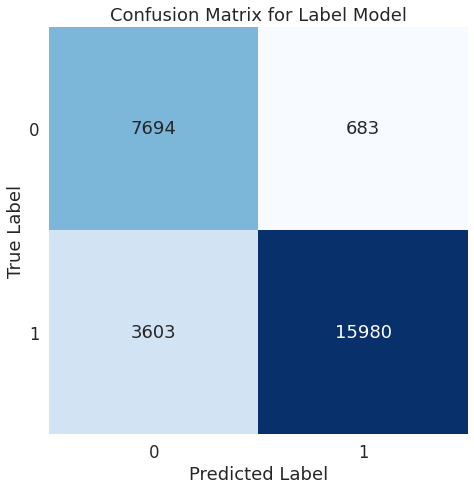

In [ ]:
# Evaluate performance of Label Model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

classes = np.unique(df_train_filtered.label)
y_test_array = pd.get_dummies(df_train_filtered.label, drop_first=False).values

# Print Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(
    df_train_filtered.label, df_train_filtered.lm_label
    )
auc = metrics.roc_auc_score(df_train_filtered.label, df_train_filtered.lm_label)
print("Accuracy:",  round(accuracy,2))
print("ROC-AUC:", round(auc,2))
print("Detail:")
print(metrics.classification_report(
    df_train_filtered.label, df_train_filtered.lm_label
    )
)
    
# Plot confusion matrix
cm = metrics.confusion_matrix(
    df_train_filtered.label, df_train_filtered.lm_label
    )
fig, ax = plt.subplots(figsize=(7.5, 7.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", xticklabels=classes, 
       yticklabels=classes, title="Confusion Matrix for Label Model")
plt.yticks(rotation=0)

plt.savefig(os.path.join(SAVE_FIG, FIG_FILE1), 
            bbox_inches='tight'
            )

plt.show(); ## F1 of 88%


### Train BERT Model

The output of the Snorkel `LabelModel` is a set of labels that can be used with most popular supervised learning models such as Logistic Regression, XGBoost, and neural networks.

In [ ]:
# Create BERT tokenizer (original BERT of 110M parameters)
# BERT tokenizer can handle punctuation, simleys, etc.
# Previously replaced mentions and urls with special tokens (#has_url, #has_mention)

bert_token = transformers.BertTokenizerFast.from_pretrained(
    'bert-base-uncased', 
    do_lower_case=True) 

# Create helper function for text parsing

def bert_encode(tweet_df, tokenizer):
    ## add '[CLS]' token as prefix to flag start of text
    ## append '[SEP]' token to flag end of text
    ## append '[PAD]' token to fill uneven text
    bert_tokens = tokenizer.batch_encode_plus(
        tweet_df['tweet'].to_list(),
        padding='max_length', 
        truncation=True,
        max_length=30
        )
    
    ## convert list to tensors
    input_word_ids = torch.tensor(bert_tokens['input_ids'])
    input_masks = torch.tensor(bert_tokens['attention_mask'])
    input_type_ids = torch.tensor(bert_tokens['token_type_ids'])

    inputs = {
        'input_word_ids': input_word_ids,
        'input_masks': input_masks,
        'input_type_ids': input_type_ids
        }

    return inputs

In [ ]:
# Apply BERT encoding for training
'''
X_train = bert_encode(df_train_filtered, bert_token)

with open(MODEL_FILE1, 'wb') as file:
    pickle.dump(X_train, file)
'''
X_train = pd.read_pickle(os.path.join(LOAD_LFS + MODEL_FILE1))
y_train = df_train.label.values ## use original training labels
y_train_lm = probs_train_filtered ## use noisy labels from Snorkel LM

'''
# Apply BERT encoding for validation
X_valid = bert_encode(df_valid, bert_token)

with open(MODEL_FILE2, 'wb') as file:
    pickle.dump(X_valid, file)

# Apply BERT encoding for testing
X_test = bert_encode(df_test, bert_token)

with open(MODEL_FILE3, 'wb') as file:
    pickle.dump(X_test, file)
'''
# Load BERT encodes for validation and testing
X_valid = pd.read_pickle(os.path.join(LOAD_MODEL, MODEL_FILE2))
y_valid = df_valid.label.values

X_test = pd.read_pickle(os.path.join(LOAD_MODEL, MODEL_FILE3))
y_test = df_test.label.values

In [ ]:
# Define helper functions to calculate accuracy

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

# Calculate accuracy for predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Return time in seconds as string hh:mm:ss
def format_time(elapsed):
    ## round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    ## format as hh:mm:ssa
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Redfine BERT model for additional fine-tuning 
nlp_bert = transformers.BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', ## use 12-layer BERT model, uncased vocab
    num_labels=2, ## binary classfication
    output_attentions = False, ## model returns attentions weights
    output_hidden_states = False, ## model returns all hidden-states
    )

nlp_bert.cuda()

# Load saved BERT model
nlp_bert.load_state_dict(torch.load(os.path.join(LOAD_LFS, BERT_PRE)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
# Get all of the model's parameters as a list of tuples

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

params = list(nlp_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(
    len(params))
)

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Create data loaders for train and test set
# Pass batches of train data and test data as input to the model during training

batch_size = 32 ## define batch size, authors recommend 16 or 32 for fine-tuning

# Wrap tensors for train
X_train_data = TensorDataset(
    X_train['input_word_ids'], 
    X_train['input_masks'], 
    torch.tensor(y_train_lm) ## use Snorkel labels
    )

# Make sampler for sampling the data during training
X_train_sampler = RandomSampler(X_train_data)

# Make dataLoader for train set
X_train_dataloader = DataLoader(
    X_train_data, 
    sampler=X_train_sampler, 
    batch_size=batch_size
    )

# Wrap tensors for valid
X_valid_data = TensorDataset(
    X_valid['input_word_ids'], 
    X_valid['input_masks'], 
    torch.tensor(y_valid)
    )

# Make sampler for sampling the data during training
X_valid_sampler = SequentialSampler(X_valid_data)

# Make dataLoader for validation set
X_valid_dataloader = DataLoader(
    X_valid_data, 
    sampler=X_valid_sampler, 
    batch_size=batch_size
    )

# Wrap tensors for test
X_test_data = TensorDataset(
    X_test['input_word_ids'], 
    X_test['input_masks'], 
    torch.tensor(y_test)
    )

# Make sampler for predicting data after training
X_test_sampler = SequentialSampler(X_test_data)

# Make dataLoader for testing set
X_test_dataloader = DataLoader(
    X_test_data, 
    sampler=X_test_sampler, 
    batch_size=batch_size
    )

In [ ]:
# Define optimizer 
optimizer = transformers.AdamW(nlp_bert.parameters(),
                               lr=2e-5, ## learning rate
                               eps=1e-8 # small number prevent divison by zero
                               ) 

# Check the class weights for imbalanced classes
class_weights = compute_class_weight(
    'balanced', 
    np.unique(y_train_lm), # use Snorkel labels
    y_train_lm
    )

print("Class Weights:", class_weights)


# Update model architecture to handle imbalanced classes
weights= torch.tensor(class_weights, dtype=torch.float) ## convert to tensor
weights = weights.to('cuda') ## push to GPU
cross_entropy  = torch.nn.NLLLoss(weight=weights) ## define the loss function


Class Weights: [1.23749668 0.83898458]


In [ ]:
# Define learning rate scheduler
epochs = 4 ## define number of training epochs

total_steps = len(X_train_dataloader) * epochs ## batches X epochs

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Run training loop

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# Loop each epoch...
for epoch_i in range(0, epochs):
    ## perform one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    ## measure how long the training epoch takes.
    t0 = time.time()

    ## reset the total loss for this epoch.
    total_train_loss = 0

    ## put the model into training mode     
    nlp_bert.train()

    ## loop each batch of training data...
    for step, batch in enumerate(X_train_dataloader):

        ## update progress every 40 batches
        if step % 40 == 0 and not step == 0:
            ## calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            ## report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(X_train_dataloader), elapsed))

        ## unpack this training batch from our dataloader
        ## NOTE: `model.to(device) is in-place operation
        ## batch (Tensor) to GPU is not in-place operation
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels

        ## Clear previously calculated gradients before performing backward pass         
        nlp_bert.zero_grad()        

        ## perform a forward pass (evaluate the model on this training batch)
        loss_logit_dict = nlp_bert(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels
                                   )
        loss =  loss_logit_dict['loss']
        logits = loss_logit_dict['logits']

        ## accumulate the training loss over all of the batches
        ## calculate the average loss at the end 
        total_train_loss += loss.item()

        ## perform a backward pass to calculate the gradients
        loss.backward()

        ## clip the norm of the gradients to 1.0
        ## prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(nlp_bert.parameters(), 1.0)

        ## update parameters and take a step using the computed gradient
        optimizer.step() ## dictates update rule based on gradients, lr, etc.

        ## update the learning rate
        scheduler.step()
    
    ## save checkpoint

    print("")
    print("Saving Checkpoint...")

    torch.save({'epoch': epoch_i,
                'model_state_dict': nlp_bert.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, 
               os.path.join(
                   SAVE_MODEL, 
                   BERT_POST_CHECKPOINT + 'epoch{}_chkpt.pt'.format(epoch_i)
                   )
                )

    ## calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(X_train_dataloader)            
    
    ## measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    ## start validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    ## put the model in evaluation mode--the dropout layers behave differently
    nlp_bert.eval()

    ## define tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    ## evaluate data for one epoch
    for batch in X_valid_dataloader:
        
        ## unpack this training batch from our dataloader
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels
        
        ## tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            ## check forward pass, calculate logit predictions
            loss_logit_dict = nlp_bert(b_input_ids,
                                    token_type_ids=None,
                                    ## segment ids for multiple sentences
                                    attention_mask=b_input_mask,
                                    labels=b_labels
                                    )
            loss =  loss_logit_dict['loss']
            logits = loss_logit_dict['logits']

        ## accumulate the validation loss
        total_eval_loss += loss.item()

        ## move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        ## calculate the accuracy for this batch of tweets
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    ## report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(X_valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    ## calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(X_valid_dataloader)
    
    ## measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    ## record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(
    format_time(time.time()-total_t0)
    )
)



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    874.    Elapsed: 0:00:05.
  Batch    80  of    874.    Elapsed: 0:00:10.
  Batch   120  of    874.    Elapsed: 0:00:15.
  Batch   160  of    874.    Elapsed: 0:00:20.
  Batch   200  of    874.    Elapsed: 0:00:24.
  Batch   240  of    874.    Elapsed: 0:00:29.
  Batch   280  of    874.    Elapsed: 0:00:34.
  Batch   320  of    874.    Elapsed: 0:00:39.
  Batch   360  of    874.    Elapsed: 0:00:44.
  Batch   400  of    874.    Elapsed: 0:00:49.
  Batch   440  of    874.    Elapsed: 0:00:54.
  Batch   480  of    874.    Elapsed: 0:00:58.
  Batch   520  of    874.    Elapsed: 0:01:03.
  Batch   560  of    874.    Elapsed: 0:01:08.
  Batch   600  of    874.    Elapsed: 0:01:13.
  Batch   640  of    874.    Elapsed: 0:01:18.
  Batch   680  of    874.    Elapsed: 0:01:23.
  Batch   720  of    874.    Elapsed: 0:01:28.
  Batch   760  of    874.    Elapsed: 0:01:32.
  Batch   800  of    874.    Elapsed: 0:01:37.
  Batch   840  of

In [ ]:
# Display floats with two decimal places
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')
'''
# A hack to force the column headers to wrap
df = df.style.set_table_styles(
    [dict(selector="th", props=[('max-width', '70px')])]
    )
'''
# Save training stats
with open(MODEL_FILE4, 'wb') as file:
    pickle.dump(df_stats, file)

# Display the table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.29,0.30,0.88,0:01:52,0:00:01
2,0.18,0.40,0.87,0:01:53,0:00:01
3,0.11,0.53,0.87,0:01:52,0:00:01
4,0.07,0.67,0.86,0:01:52,0:00:01


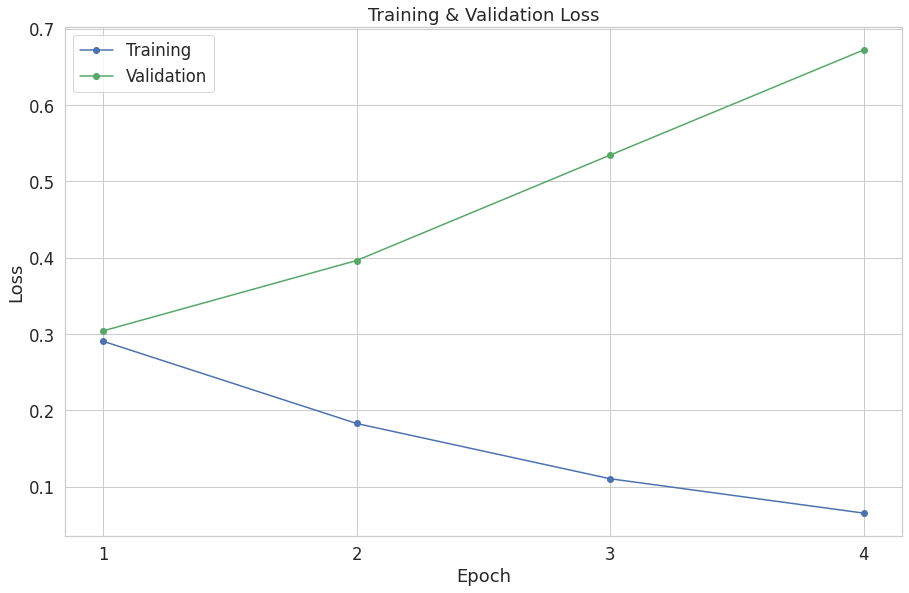

In [ ]:
# Increase the plot size and font size
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15/1.6))

# Plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.savefig(os.path.join(SAVE_FIG, FIG_FILE2), 
            bbox_inches='tight'
            )

plt.show();

# Overfitting if training loss << validation loss
# Underfitting if training loss >> validation loss
# Just right if training loss ~ validation loss

In [ ]:
# Redfine BERT model for additional fine-tuning with epoch = 1
nlp_bert = transformers.BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', ## use 12-layer BERT model, uncased vocab
    num_labels=2, ## binary classfication
    output_attentions = False, ## model returns attentions weights
    output_hidden_states = False, ## model returns all hidden-states
    )

nlp_bert.cuda()

# Load saved BERT model
nlp_bert.load_state_dict(torch.load(os.path.join(LOAD_LFS, BERT_PRE)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
# Define learning rate scheduler
epochs = 1 ## define number of training epochs
total_steps = len(X_train_dataloader) * epochs ## batches best epoch = 1

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Run training loop

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# Loop each epoch...
for epoch_i in range(0, epochs):
    ## perform one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    ## measure how long the training epoch takes.
    t0 = time.time()

    ## reset the total loss for this epoch.
    total_train_loss = 0

    ## put the model into training mode     
    nlp_bert.train()

    ## loop each batch of training data...
    for step, batch in enumerate(X_train_dataloader):

        ## update progress every 40 batches
        if step % 40 == 0 and not step == 0:
            ## calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            ## report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(X_train_dataloader), elapsed))

        ## unpack this training batch from our dataloader
        ## NOTE: `model.to(device) is in-place operation
        ## batch (Tensor) to GPU is not in-place operation
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels

        ## Clear previously calculated gradients before performing backward pass         
        nlp_bert.zero_grad()        

        ## perform a forward pass (evaluate the model on this training batch)
        loss_logit_dict = nlp_bert(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels
                                   )
        loss =  loss_logit_dict['loss']
        logits = loss_logit_dict['logits']

        ## accumulate the training loss over all of the batches
        ## calculate the average loss at the end 
        total_train_loss += loss.item()

        ## perform a backward pass to calculate the gradients
        loss.backward()

        ## clip the norm of the gradients to 1.0
        ## prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(nlp_bert.parameters(), 1.0)

        ## update parameters and take a step using the computed gradient
        optimizer.step() ## dictates update rule based on gradients, lr, etc.

        ## update the learning rate
        scheduler.step()
    
    ## save checkpoint

    print("")
    print("Saving Checkpoint...")

    torch.save({'epoch': epoch_i,
                'model_state_dict': nlp_bert.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, 
               os.path.join(
                   SAVE_MODEL, 
                   BERT_POST_CHECKPOINT + 'epoch{}_chkpt.pt'.format(epoch_i)
                   )
                )

    ## calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(X_train_dataloader)            
    
    ## measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    ## start validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    ## put the model in evaluation mode--the dropout layers behave differently
    nlp_bert.eval()

    ## define tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    ## evaluate data for one epoch
    for batch in X_valid_dataloader:
        
        ## unpack this training batch from our dataloader
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels
        
        ## tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            ## check forward pass, calculate logit predictions
            loss_logit_dict = nlp_bert(b_input_ids,
                                    token_type_ids=None,
                                    ## segment ids for multiple sentences
                                    attention_mask=b_input_mask,
                                    labels=b_labels
                                    )
            loss =  loss_logit_dict['loss']
            logits = loss_logit_dict['logits']

        ## accumulate the validation loss
        total_eval_loss += loss.item()

        ## move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        ## calculate the accuracy for this batch of tweets
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    ## report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(X_valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    ## calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(X_valid_dataloader)
    
    ## measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    ## record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(
    format_time(time.time()-total_t0)
    )
)



======== Epoch 1 / 1 ========
Training...
  Batch    40  of    874.    Elapsed: 0:00:05.
  Batch    80  of    874.    Elapsed: 0:00:10.
  Batch   120  of    874.    Elapsed: 0:00:15.
  Batch   160  of    874.    Elapsed: 0:00:20.
  Batch   200  of    874.    Elapsed: 0:00:24.
  Batch   240  of    874.    Elapsed: 0:00:29.
  Batch   280  of    874.    Elapsed: 0:00:34.
  Batch   320  of    874.    Elapsed: 0:00:39.
  Batch   360  of    874.    Elapsed: 0:00:44.
  Batch   400  of    874.    Elapsed: 0:00:49.
  Batch   440  of    874.    Elapsed: 0:00:54.
  Batch   480  of    874.    Elapsed: 0:00:58.
  Batch   520  of    874.    Elapsed: 0:01:03.
  Batch   560  of    874.    Elapsed: 0:01:08.
  Batch   600  of    874.    Elapsed: 0:01:13.
  Batch   640  of    874.    Elapsed: 0:01:18.
  Batch   680  of    874.    Elapsed: 0:01:23.
  Batch   720  of    874.    Elapsed: 0:01:27.
  Batch   760  of    874.    Elapsed: 0:01:32.
  Batch   800  of    874.    Elapsed: 0:01:37.
  Batch   840  of

In [ ]:
# Save current state with best parameters
'''
torch.save(nlp_bert.state_dict(), 
           os.path.join(SAVE_MODEL, BERT_POST_DICT)
           )

# Save full model
torch.save(nlp_bert, os.path.join(SAVE_MODEL, BERT_POST_FULL))
'''

In [ ]:
# Redfine BERT model for additional fine-tuning 
nlp_bert = transformers.BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', ## use 12-layer BERT model, uncased vocab
    num_labels=2, ## binary classfication
    output_attentions = False, ## model returns attentions weights
    output_hidden_states = False, ## model returns all hidden-states
    )

nlp_bert.cuda()

# Load saved BERT model
nlp_bert.load_state_dict(torch.load(os.path.join(LOAD_LFS, BERT_POST_DICT)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
# Prediction on test set

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

print('Predicting labels for {:,} test sentences...'.format(
    len(X_test['input_word_ids'])))

# Put model in evaluation mode
nlp_bert.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in X_test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to('cuda') for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = nlp_bert(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 6,337 test sentences...
    DONE.


In [ ]:
preds_prob[:, 1]

array([0.41733934, 0.19579266, 0.94976125, ..., 0.88107774, 0.88826131,
       0.31487056])

In [ ]:
# Flatten arrays into single list
y_test_true = [item for sublist in true_labels for item in sublist]
y_test_preds = [np.argmax(item) for sublist in 
                predictions for item in sublist]

# Convert logit to odds to probability
preds_prob = np.array(
    [[np.exp(a) / (1 + np.exp(a)), np.exp(b) / (1 + np.exp(b))] 
     for sublist in predictions for a,b in sublist]
     )

Accuracy: 0.84
ROC-AUC: 0.87
Detail:
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1894
           1       0.97      0.80      0.88      4443

    accuracy                           0.84      6337
   macro avg       0.82      0.87      0.83      6337
weighted avg       0.88      0.84      0.85      6337



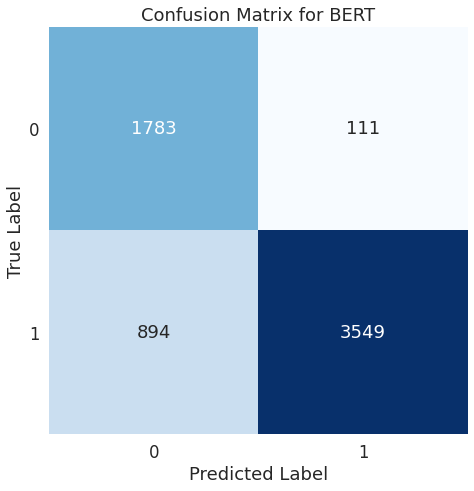

In [ ]:
# Evaluate performance of BERT

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

classes = np.unique(y_test_true)
y_test_array = pd.get_dummies(y_test_true, drop_first=False).values

# Print Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_true, y_test_preds)
auc = metrics.roc_auc_score(y_test_true, y_test_preds)
print("Accuracy:",  round(accuracy,2))
print("ROC-AUC:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_true, y_test_preds))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_test_true, y_test_preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", xticklabels=classes, 
       yticklabels=classes, title="Confusion Matrix for BERT")
plt.yticks(rotation=0)

plt.savefig(os.path.join(SAVE_FIG, FIG_FILE3), 
            bbox_inches='tight'
            )

plt.show(); ## F1 score of 88%


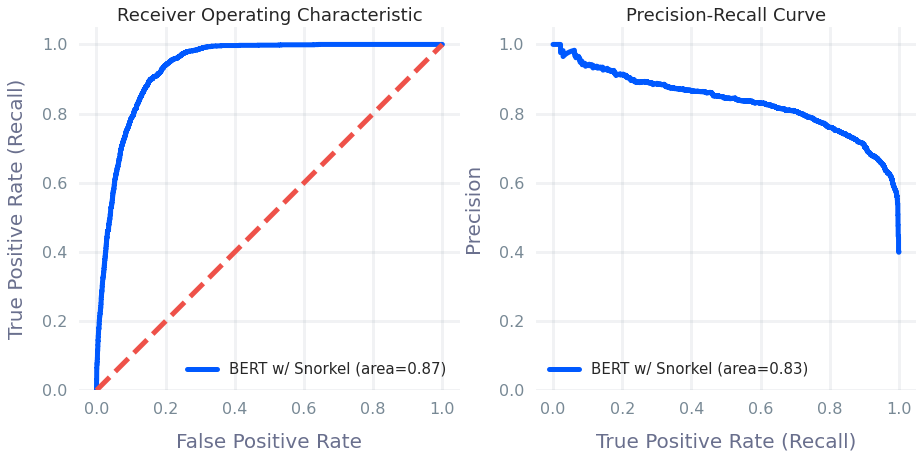

In [ ]:
# Evaluate performance of BERT model

# Code adapted from Mauro Di Pietro
# >>> https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# Plot ROC
classes_name = ['NO_ABUSE', 'ABUSE      ']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/1.6))

fpr, tpr, thresholds = metrics.roc_curve(
    y_test_array[:,0], preds_prob[:,0]
    )
ax1.plot(fpr, tpr, color=COLORS[0], lw=LINEWIDTH, alpha=1.0,
         label='BERT w/ Snorkel (area={0:0.2f})'.format(
             metrics.roc_auc_score(y_test_true, y_test_preds)
             )
        )
ax1.plot([0,1], [0,1], color=RED, linewidth=LINEWIDTH, linestyle='--')

ax1.set_adjustable('box')
ax1.set(xlim=[-0.05,1.05], ylim=[0.0,1.05], aspect=1,
        title="Receiver Operating Characteristic"
        )
ax1.set_xlabel('False Positive Rate', color=DARK_GREY, fontsize=20, 
                 alpha=0.6, labelpad=16
                 )
ax1.set_ylabel('True Positive Rate (Recall)', color=DARK_GREY, fontsize=20, 
                 alpha=0.6, labelpad=16
                 )
ax1.tick_params(axis='both', labelsize=16, length=8, colors=GREY)
ax1.legend(loc="lower right", frameon=False, fontsize='small')

ax1.grid(b=True, color=GREY, alpha=0.1, linewidth=3)

for spine in ['top', 'right', 'left', 'bottom']:
    ax1.spines[spine].set_visible(False)

# Plot precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(
                y_test_array[:,0], preds_prob[:,0])

ax2.plot(recall, precision, color=COLORS[0], lw=LINEWIDTH, alpha=1.0,
            label='BERT w/ Snorkel (area={0:0.2f})'.format(
                metrics.auc(recall, precision)
                )
        )

ax2.set(xlim=[-0.05,1.05], ylim=[0.0,1.05], aspect=1,
        title="Precision-Recall Curve"
        )
ax2.set_xlabel('True Positive Rate (Recall)', color=DARK_GREY, fontsize=20, 
                 alpha=0.6, labelpad=16
                 )
ax2.set_ylabel('Precision', color=DARK_GREY, fontsize=20, 
                 alpha=0.6, labelpad=16
                 )
ax2.tick_params(axis='both', labelsize=16, length=8, colors=GREY)
ax2.legend(loc="lower left", frameon=False, fontsize='small')
ax2.set_adjustable('box')
ax2.grid(b=True, color=GREY, alpha=0.1, linewidth=3)

for spine in ['top', 'right', 'left', 'bottom']:
    ax2.spines[spine].set_visible(False)

plt.savefig(os.path.join(SAVE_FIG, FIG_FILE4), 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none'
            )

plt.show();